Medicare is a federal health insurance program in the U.S. that covers individuals aged 65 or older, younger people with disabilities receiving Social Security Disability Insurance (SSDI), and those with End-Stage Renal Disease (ESRD) requiring dialysis or a transplant. The CMS (Centers for Medicare & Medicaid Services), which manages Medicare funding, published data for 2013 and 2014 in Google Cloud. BigQuery was utilized to explore and visualize this database.

The following code is to authenticate and set up a client for interacting with Google BigQuery using a service account JSON key. Prerequistion: open a google cloud account and get BigQuery API key in JSON format.

In [ ]:
# import library for analysis
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from google.cloud import bigquery
import zipcodes as zcode
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from plotly.offline import iplot
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import os
import time
from google.cloud import bigquery
import os

# Set the environment variable for authentication
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "ultra-airway-443316-u4-071c23200e61.json"

# Create a BigQuery client
client = bigquery.Client()

# Get the table ids from the database
# Specify the dataset ID
dataset_id = "bigquery-public-data.cms_medicare"

# Create a DatasetReference object
dataset_ref = bigquery.DatasetReference.from_string(dataset_id)

# Fetch the dataset
dataset = client.get_dataset(dataset_ref)  # This will fetch the dataset metadata

# List tables in the dataset
tables = list(client.list_tables(dataset))  # List all tables

# Print table names
print(f"Tables in dataset {dataset_id}:")
for table in tables:
    print(table.table_id)

Tables in dataset bigquery-public-data.cms_medicare:
home_health_agencies_2013
home_health_agencies_2014
hospice_providers_2014
hospital_general_info
inpatient_charges_2011
inpatient_charges_2012
inpatient_charges_2013
inpatient_charges_2014
inpatient_charges_2015
nursing_facilities_2013
nursing_facilities_2014
outpatient_charges_2011
outpatient_charges_2012
outpatient_charges_2013
outpatient_charges_2014
outpatient_charges_2015
part_d_prescriber_2014
physicians_and_other_supplier_2012
physicians_and_other_supplier_2013
physicians_and_other_supplier_2014
physicians_and_other_supplier_2015
referring_durable_medical_equip_2013
referring_durable_medical_equip_2014


In [ ]:
#  visualizing the schema of a BigQuery table ("home_healt") in a user-friendly, formatted table format.
table_id = "home_health_agencies_2013"

# Fetch table schema
table = client.get_table(f"{dataset_id}.{table_id}")  # Get the table
schema = table.schema

# Convert schema to a DataFrame for display
schema_df = pd.DataFrame(
    [(field.name, field.field_type, field.mode) for field in schema],
    columns=["Column Name", "Data Type", "Mode"]
)

# Style the DataFrame for display
styled_schema = schema_df.style.set_properties(
    **{
        'background-color': '#AFE1AF',
        'color': 'black',
        'border-color': 'black'
    }
)

styled_schema

Non-LUPA: A non-LUPA episode occurs when a home health agency provides more than 4 visits to a patient during a 60-day period. In this case, the agency receives the full payment rate for the episode, as opposed to the reduced payment applied for LUPA episodes (fewer than 5 visits).



In [30]:
table_id = "home_health_agencies_2014"

# Fetch table schema
table = client.get_table(f"{dataset_id}.{table_id}")  # Get the table
schema = table.schema

# Convert schema to a DataFrame for display
schema_df = pd.DataFrame(
    [(field.name, field.field_type, field.mode) for field in schema],
    columns=["Column Name", "Data Type", "Mode"]
)

# Style the DataFrame for display
styled_schema = schema_df.style.set_properties(
    **{
        'background-color': '#AFE1AF',
        'color': 'black',
        'border-color': 'black'
    }
)

styled_schema

In [ ]:
# Overview "home_health_agencies_2013" table
df_home_health_2013.head(5).style.set_properties(**{'background-color': '#AFE1AF',
                           'color': 'black',
                           'border-color': 'black'})

In [ ]:
# Overview "home_health_agencies_2014" table
df_home_health_2014.head(5).style.set_properties(**{'background-color': '#AFE1AF',
                           'color': 'black',
                           'border-color': 'black'})

In [ ]:
def describe(dataset):
    """
    Provides an overview of the dataset, detailing each column's attributes such as data type, count, number of unique values, missing values, and minimum/maximum values for numeric columns.

    Parameters:
        dataset (pd.DataFrame): The input dataset.

    Returns:
        pd.DataFrame: A summary DataFrame with descriptive statistics for each column.
    """
    # Lists to hold descriptive statistics
    variables = dataset.columns
    dtypes = dataset.dtypes
    count = dataset.notna().sum()  # Non-missing values
    unique = dataset.nunique()  # Unique values
    missing = dataset.isna().sum()  # Missing values

    # Min and max values for numeric columns, 'N/A' for non-numeric
    min_ = dataset.apply(lambda col: col.min() if col.dtypes in ['float64', 'int64'] else 'N/A')
    max_ = dataset.apply(lambda col: col.max() if col.dtypes in ['float64', 'int64'] else 'N/A')

    # Create a DataFrame with all the statistics
    summary = pd.DataFrame({
        'Variable': variables,
        'Dtype': dtypes,
        'Count': count,
        'Unique': unique,
        'Missing Values': missing,
        'Min': min_,
        'Max': max_
    }).reset_index(drop=True)

    return summary


In [12]:
Styles = [dict(selector = "caption",
               props = [("color", "white"), 
                        ("text-align", "center"),
                       ('font-size', '15pt'),
                       ('background-color', '#008080')])]

In [13]:
desc_df = describe(df_home_health_2013)
desc_df = desc_df.style.set_caption('Overview of the dataset (home_health_agencies_2013)').set_table_styles(Styles)
desc_df.set_properties(**{'background-color': '#AFE1AF',
                           'color': 'black',
                           'border-color': 'black'})

In [14]:
desc_df = describe(df_home_health_2014)
desc_df = desc_df.style.set_caption('Overview of the dataset (home_health_agencies_2014)').set_table_styles(Styles)
desc_df.set_properties(**{'background-color': '#AFE1AF',
                           'color': 'black',
                           'border-color': 'black'})

Zipcode Extraction

Zipcodes are valuable for extracting geographic information, such as latitude and longitude. In this project, I used these two data points to create engaging plots for data visualization.

In [ ]:
import numpy as np

# Assuming 'zcode' is an object you have defined elsewhere for matching zip codes.
list_zipcode = list(df_home_health_2013['zip_code'])

lat = []
long = []

for x in list_zipcode:
    my_city_county = zcode.matching(str(x))
    if len(my_city_county) == 1:
        Lat = my_city_county[0].get('lat')
        Long = my_city_county[0].get('long')
    else:
        Lat = np.nan  # Fixed: Use 'np.nan' (lowercase 'n')
        Long = np.nan  # Fixed: Use 'np.nan' (lowercase 'n')
    
    lat.insert(0, Lat)
    long.insert(0, Long)
    
# Reverse the lists to match the order of the original DataFrame
lat.reverse()
long.reverse()

# Add new columns to the DataFrame
df_home_health_2013.insert(5, 'Latitude', lat)
df_home_health_2013.insert(6, 'Longitude', long)

# Define a function to highlight specific columns (as per your initial intention)
def highlight_cols(s):
    color = '#AAFF00'
    return 'background-color: %s' % color

In [17]:
# Convert the 'zip_code' column to a list
list_zipcode = list(df_home_health_2014['zip_code'])

# Initialize lists to store latitude and longitude values
lat = []
long = []

# Iterate through each zip code and match to get latitude and longitude
for x in list_zipcode:
    my_city_county = zcode.matching(str(x))
    if len(my_city_county) == 1:
        Lat = my_city_county[0].get('lat')
        Long = my_city_county[0].get('long')
    else:
        Lat = np.nan  # Use 'np.nan' (lowercase 'n') to represent missing values
        Long = np.nan  # Use 'np.nan' (lowercase 'n') to represent missing values

    # Append values to the lists
    lat.insert(0, Lat)
    long.insert(0, Long)

# Reverse the lists to match the original DataFrame order
lat.reverse()
long.reverse()

# Add new columns for latitude and longitude to the DataFrame
df_home_health_2014.insert(5, 'Latitude', lat)
df_home_health_2014.insert(6, 'Longitude', long)

# Define a function to highlight columns with a specific background color
def highlight_cols(s):
    color = '#AAFF00'  # Set the background color
    return 'background-color: %s' % color


In [18]:
df_home_health_2013.head(5).style.set_properties(**{'background-color': '#AFE1AF',
                           'color': 'black',
                           'border-color': 'black'}).applymap(highlight_cols, 
                                                               subset=pd.IndexSlice[:, ['Latitude','Longitude']])

/var/folders/6d/k1kp92h91dg01vysfjhpw89m0000gn/T/ipykernel_22086/2089831354.py:3: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



Map Plot

The scatter mapbox in Plotly is an effective way to visualize data on a map. This plot type requires latitude and longitude coordinates, which we have, along with other variables to adjust the size and color of data points for better value differentiation.

In [19]:
df_home_health_2013['Latitude'] = df_home_health_2013['Latitude'].astype('float')
df_home_health_2013['Longitude'] = df_home_health_2013['Longitude'].astype('float')

fig = px.scatter_mapbox(df_home_health_2013, lat="Latitude", lon="Longitude", 
                        hover_name="total_episodes_non_lupa",
                        size = "total_hha_charge_amount_non_lupa",
                        color_discrete_sequence=["green"], zoom=3.5, height=500)

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])

fig.update_layout(
    annotations = [dict(x=0.5, y=0.9,
                      bgcolor= "#00FFFF",
                      showarrow=False,
                      text = "total_episodes_non_lupa and total_hha_charge_amount_non_lupa 2013")],
    title_x=0.5,
    title_y=0.9,
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [20]:
df_home_health_2013.columns

Index(['provider_id', 'agency_name', 'street_address', 'city', 'state',
       'Latitude', 'Longitude', 'zip_code', 'total_episodes_non_lupa',
       'distinct_users_non_lupa', 'total_hha_charge_amount_non_lupa',
       'total_hha_medicare_payment_amount_non_lupa',
       'total_hha_medicare_standard_payment_amount_non_lupa',
       'outlier_payments_as_a_percent_of_medicare_payment_amount_non_lupa',
       'total_lupa_episodes', 'total_hha_medicare_payment_amount_for_lupas'],
      dtype='object')

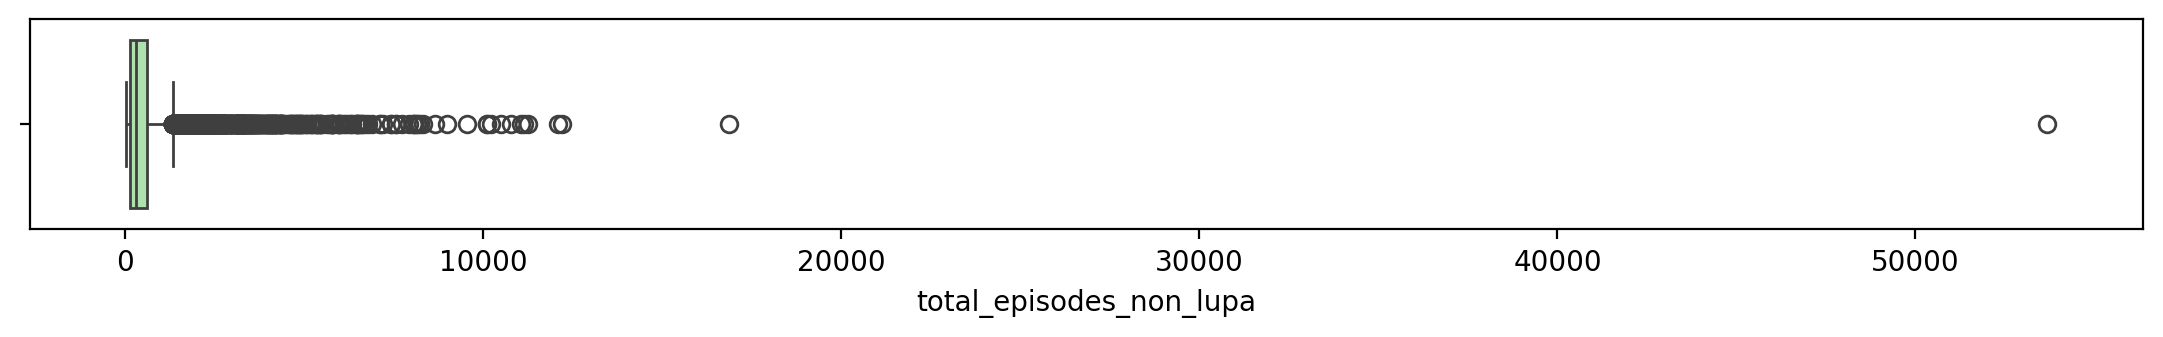

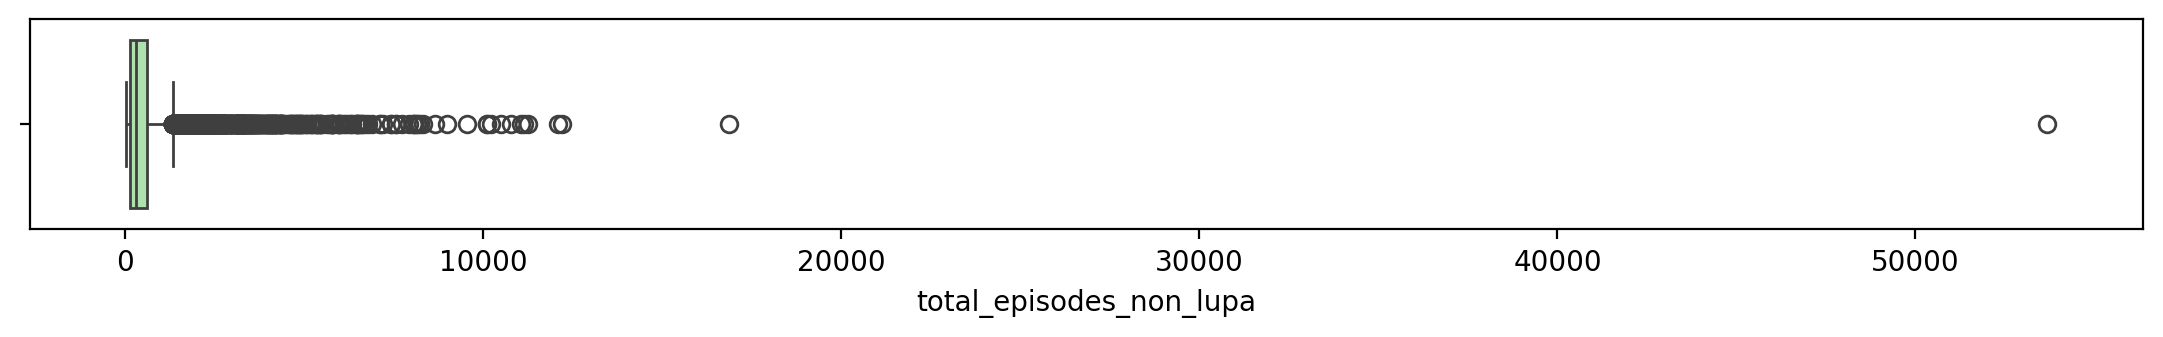

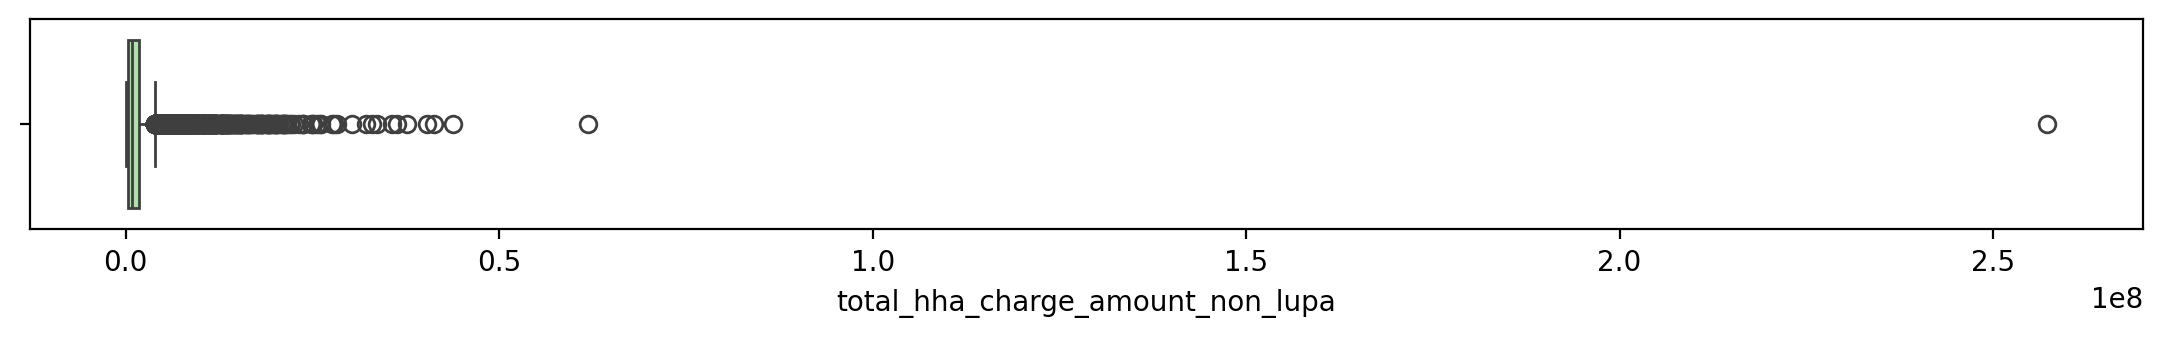

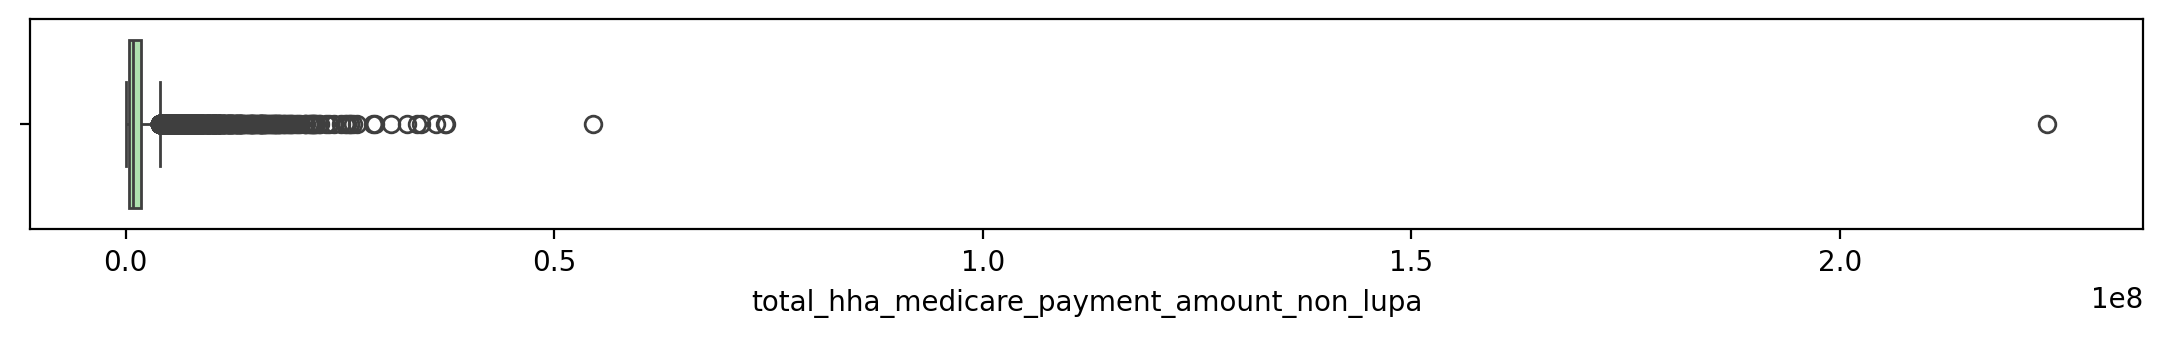

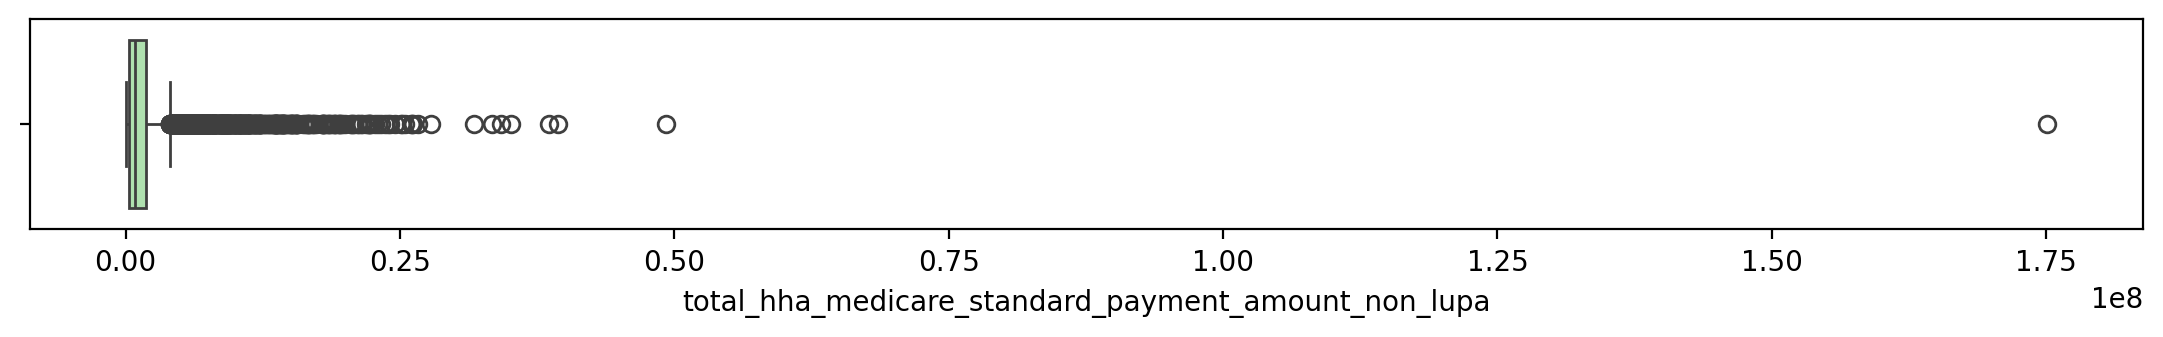

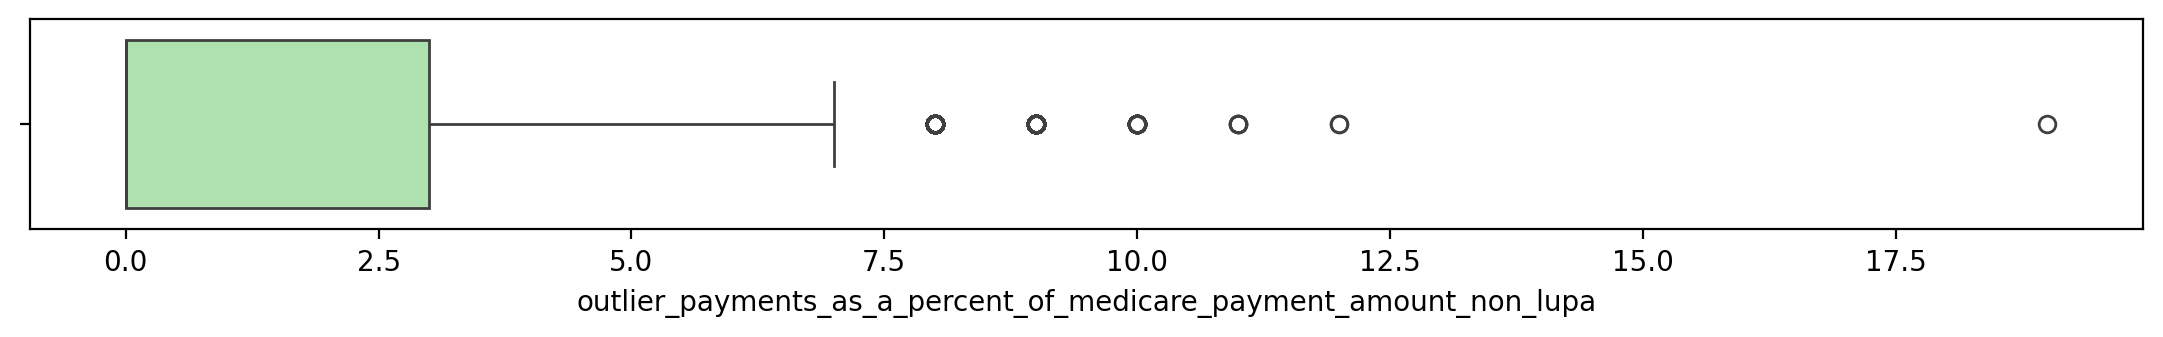

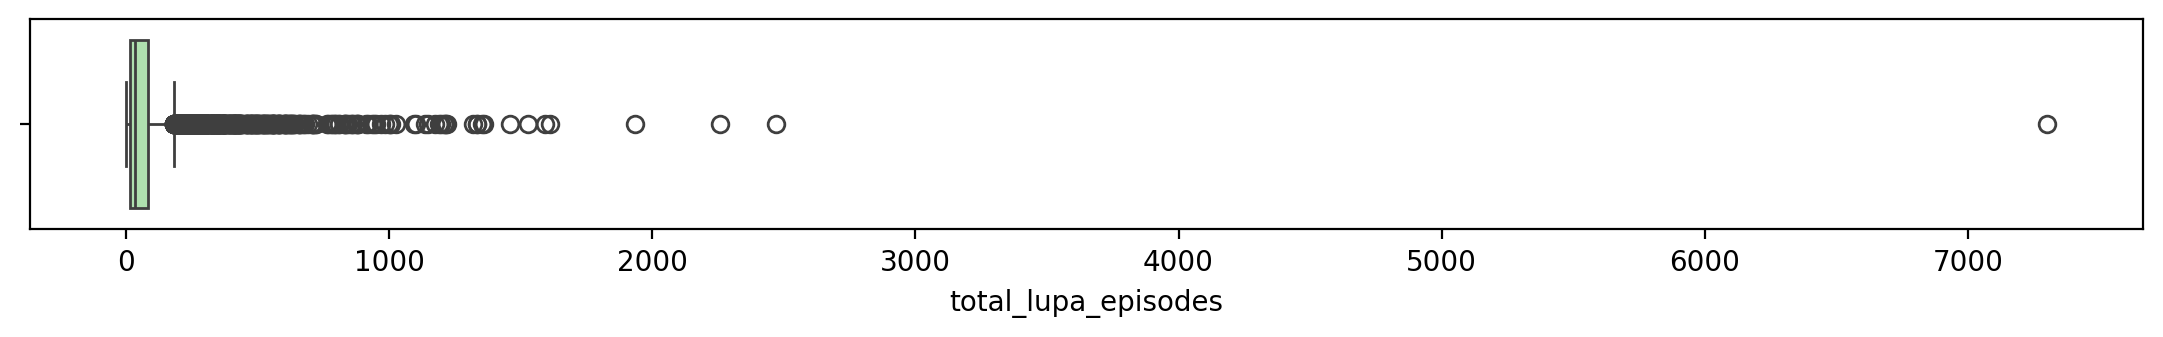

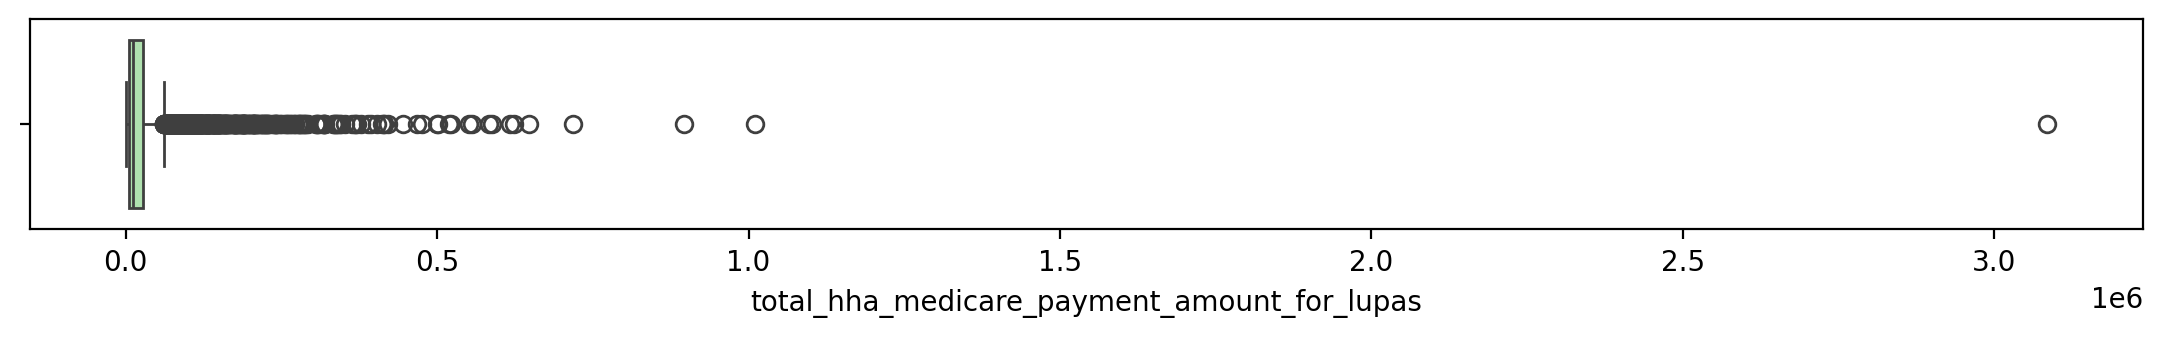

In [21]:
Numerical = ['total_episodes_non_lupa', 'total_episodes_non_lupa',
             'total_hha_charge_amount_non_lupa','total_hha_medicare_payment_amount_non_lupa',
             'total_hha_medicare_standard_payment_amount_non_lupa',
             'outlier_payments_as_a_percent_of_medicare_payment_amount_non_lupa',
             'total_lupa_episodes','total_hha_medicare_payment_amount_for_lupas']
i = 0
while i < 8:
    fig = plt.figure(figsize = [30,3], dpi=200)
    plt.subplot(2,2,1)
    sns.boxplot(x = Numerical[i], data = df_home_health_2013,
           boxprops = dict(facecolor = "#AFE1AF"))
    i += 1
    plt.show()

In [22]:
_noise1 = df_home_health_2013[df_home_health_2013["total_episodes_non_lupa"]>13000].index
print(_noise1)
df_home_health_2013.loc[_noise1].style.set_properties(**{'background-color': '#AFE1AF',
                           'color': 'black',
                           'border-color': 'black'})

Index([4123, 6038], dtype='int64')


ere are two data points that can be removed for more accurate analysis. One is located in New York, and the other in Waltham. These points are considered noise and could skew the results.

In [23]:
df_home_health_2013.drop(index=_noise1, inplace=True)

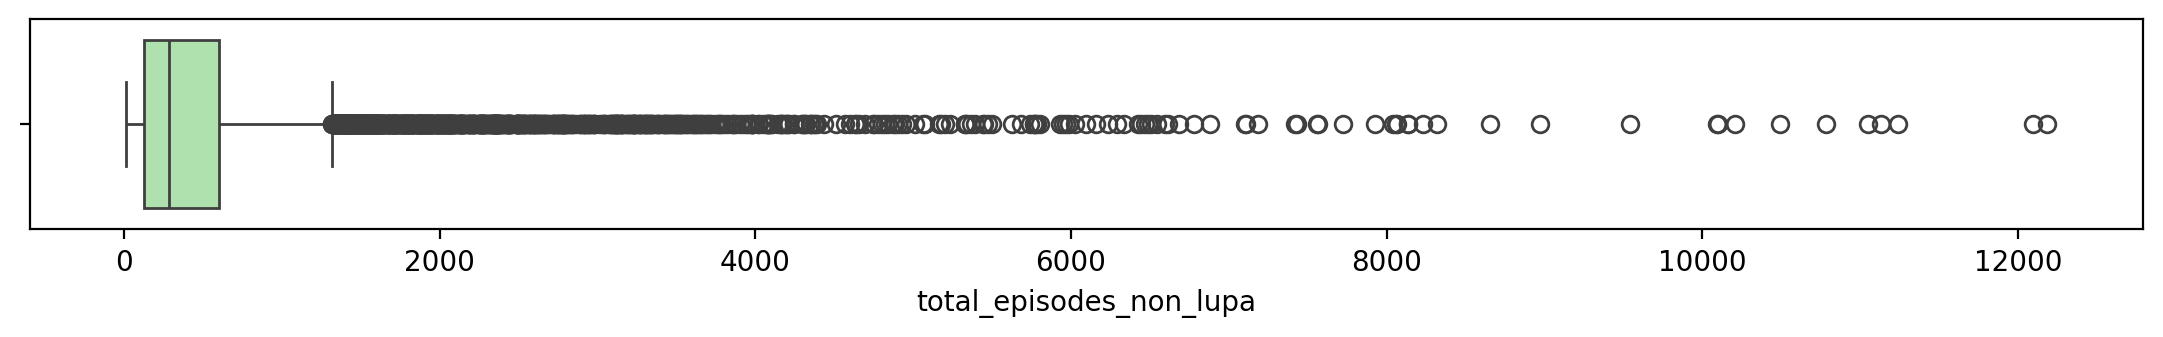

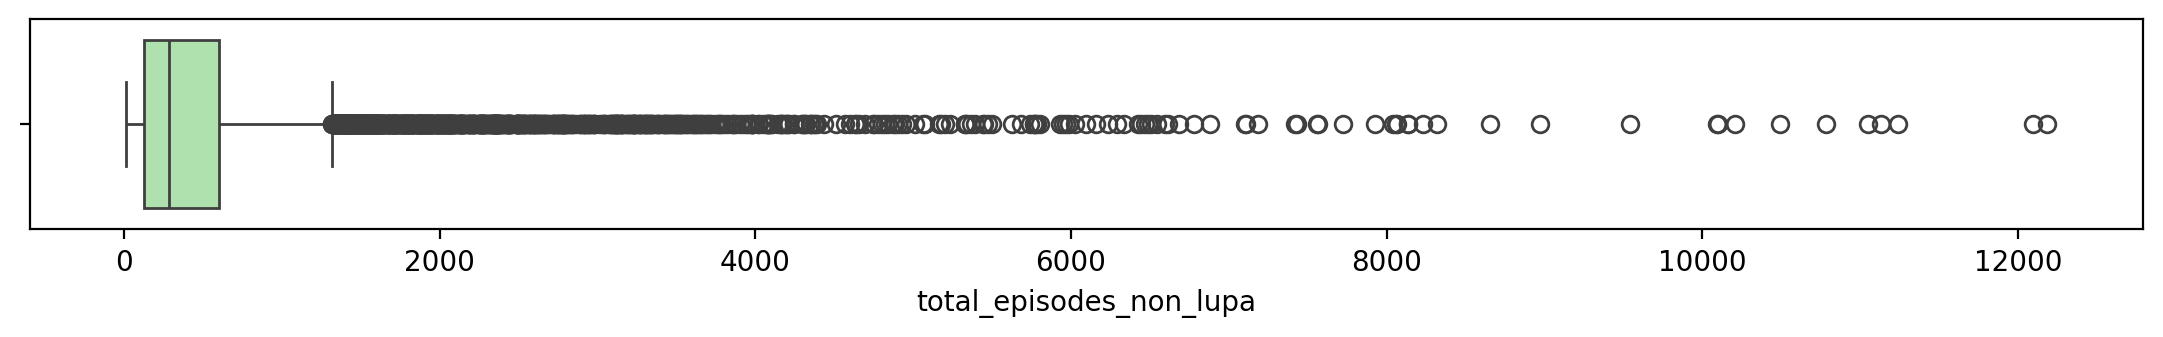

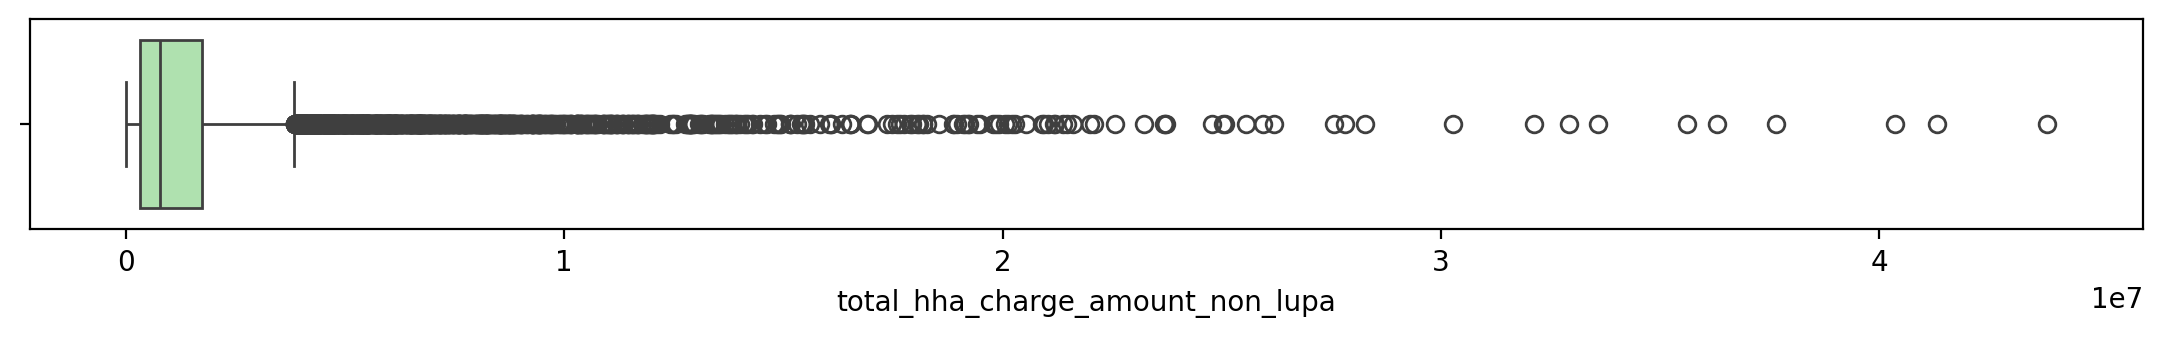

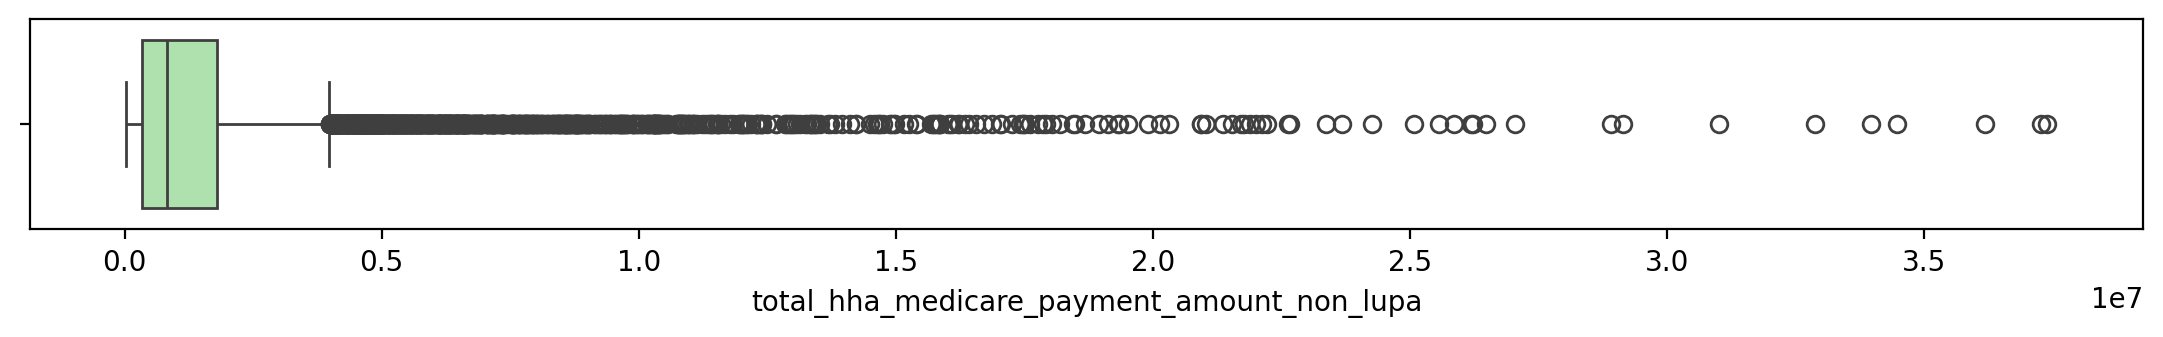

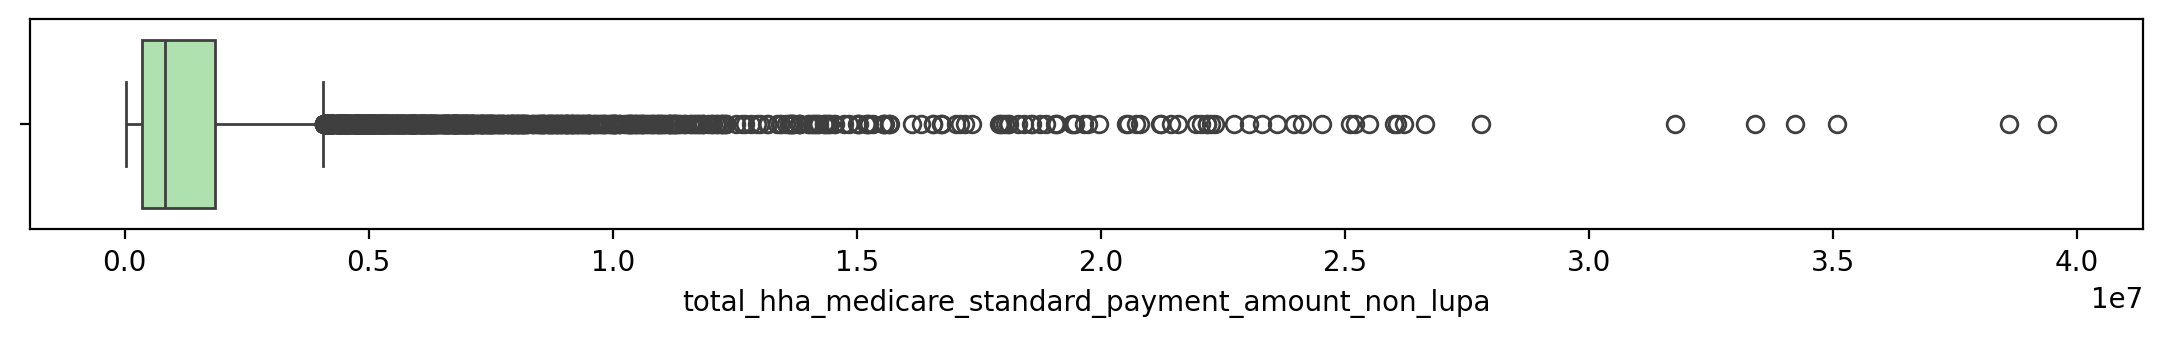

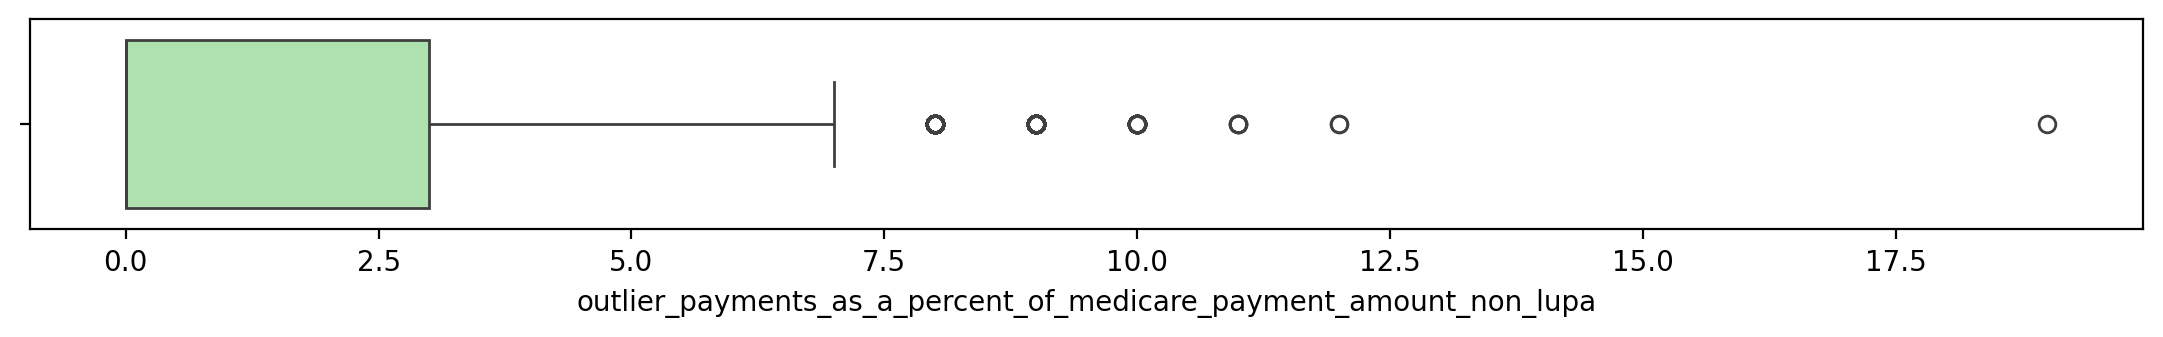

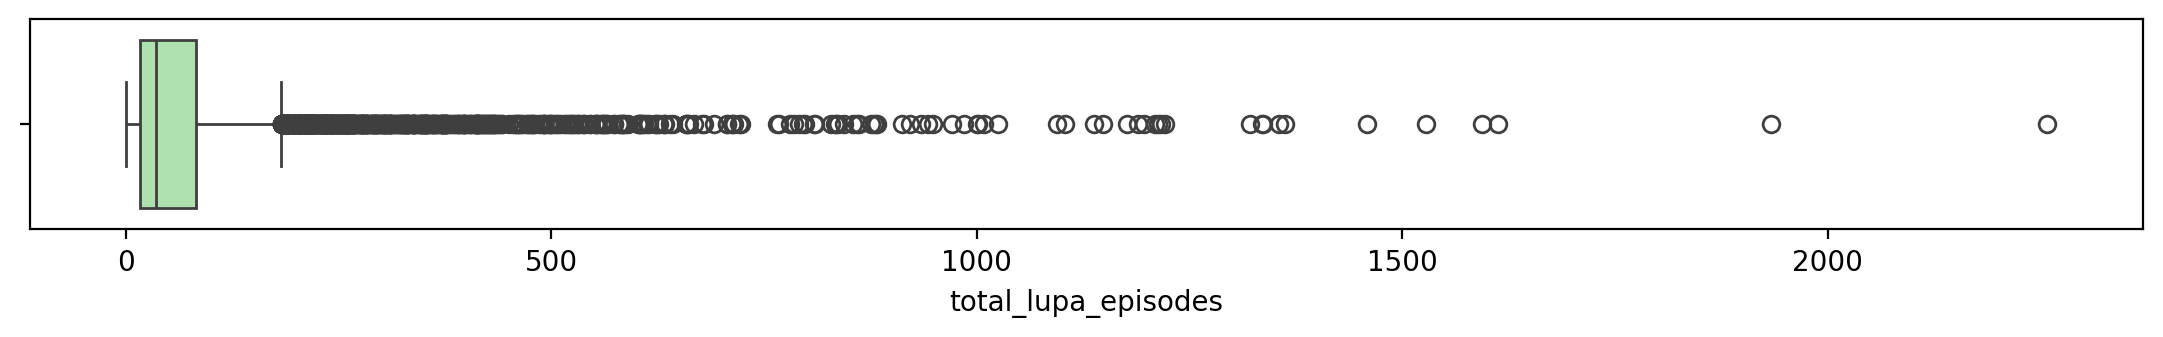

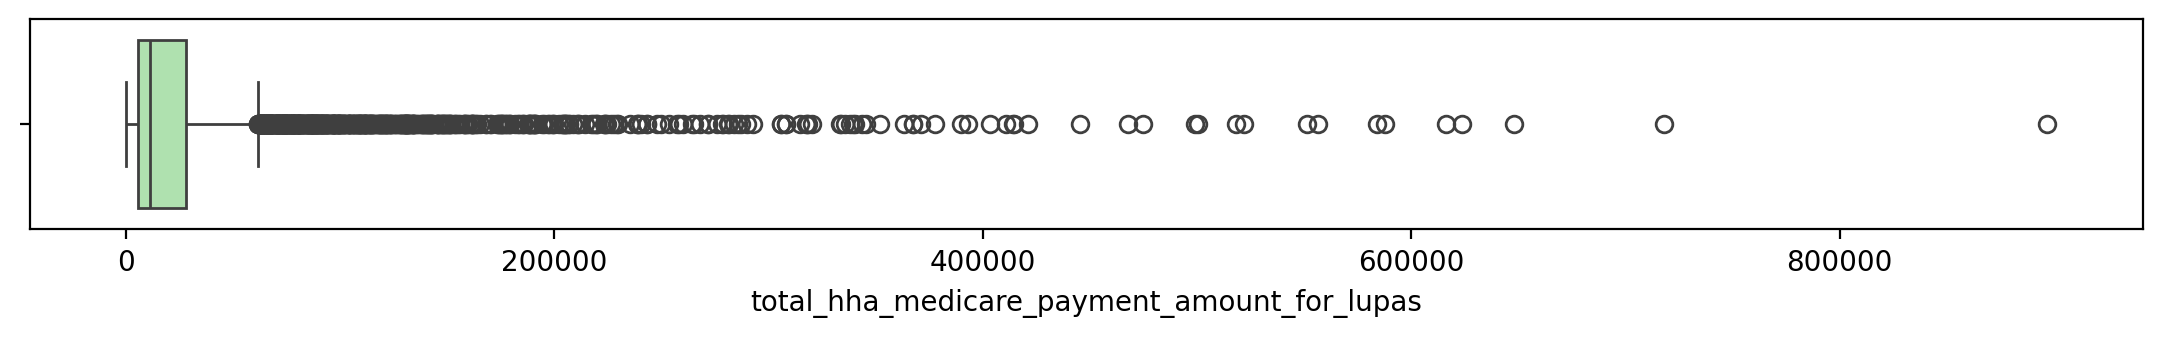

In [24]:
Numerical = ['total_episodes_non_lupa', 'total_episodes_non_lupa',
             'total_hha_charge_amount_non_lupa','total_hha_medicare_payment_amount_non_lupa',
             'total_hha_medicare_standard_payment_amount_non_lupa',
             'outlier_payments_as_a_percent_of_medicare_payment_amount_non_lupa',
             'total_lupa_episodes','total_hha_medicare_payment_amount_for_lupas']
i = 0
while i < 8:
    fig = plt.figure(figsize = [30,3], dpi=200)
    plt.subplot(2,2,1)
    sns.boxplot(x = Numerical[i], data = df_home_health_2013,
           boxprops = dict(facecolor = "#AFE1AF"))
    i += 1
    plt.show()

In [25]:
df_home_health_2013['Latitude'] = df_home_health_2013['Latitude'].astype('float')
df_home_health_2013['Longitude'] = df_home_health_2013['Longitude'].astype('float')

fig = px.scatter_mapbox(df_home_health_2013, lat="Latitude", lon="Longitude", 
                        hover_name="total_episodes_non_lupa",
                        size = "total_hha_charge_amount_non_lupa",
                        color_discrete_sequence=["green"], zoom=3.5, height=500)
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.update_layout(
    annotations = [dict(x=0.5, y=0.9,
                      bgcolor= "#00FFFF",
                      showarrow=False,
                      text = "total_episodes_non_lupa and total_hha_charge_amount_non_lupa 2013")],
    title_x=0.5,
    title_y=0.9,
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


fig.show()

In [ ]:
# Define the query
Query3 = """SELECT
state, COUNT(state) as total_facilities
FROM
  `bigquery-public-data.cms_medicare.home_health_agencies_2013`
GROUP BY 
  state
ORDER BY
  total_facilities DESC;"""

# Execute the query and convert the result to a Pandas DataFrame
query_job = client.query(Query3)
response1 = query_job.to_dataframe()

# Display the top 10 rows
print(response1.head(10))

# Create the data for the choropleth
data = [dict(
    type='choropleth',
    colorscale='greens',
    autocolorscale=False,
    locations=response1['state'],
    z=response1['total_facilities'],
    locationmode='USA-states',
    text=response1['state'],
    marker=dict(
        line=dict(
            color='rgb(255,255,255)',
            width=2
        )),
    colorbar=dict(
        title="Facilities in Different States")
)]

# Define the layout
layout = dict(
    title='Home Health Agencies Facilities in Different States',
    geo=dict(
        scope='usa',
        projection=dict(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    )
)

# Create and display the figure
fig = dict(data=data, layout=layout)
import plotly.offline as pyo
pyo.iplot(fig, filename='d3-cloropleth-map')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



  state  total_facilities
0    TX              2347
1    FL              1288
2    CA              1096
3    IL               783
4    MI               629
5    OH               527
6    PA               303
7    OK               251
8    VA               212
9    IN               211


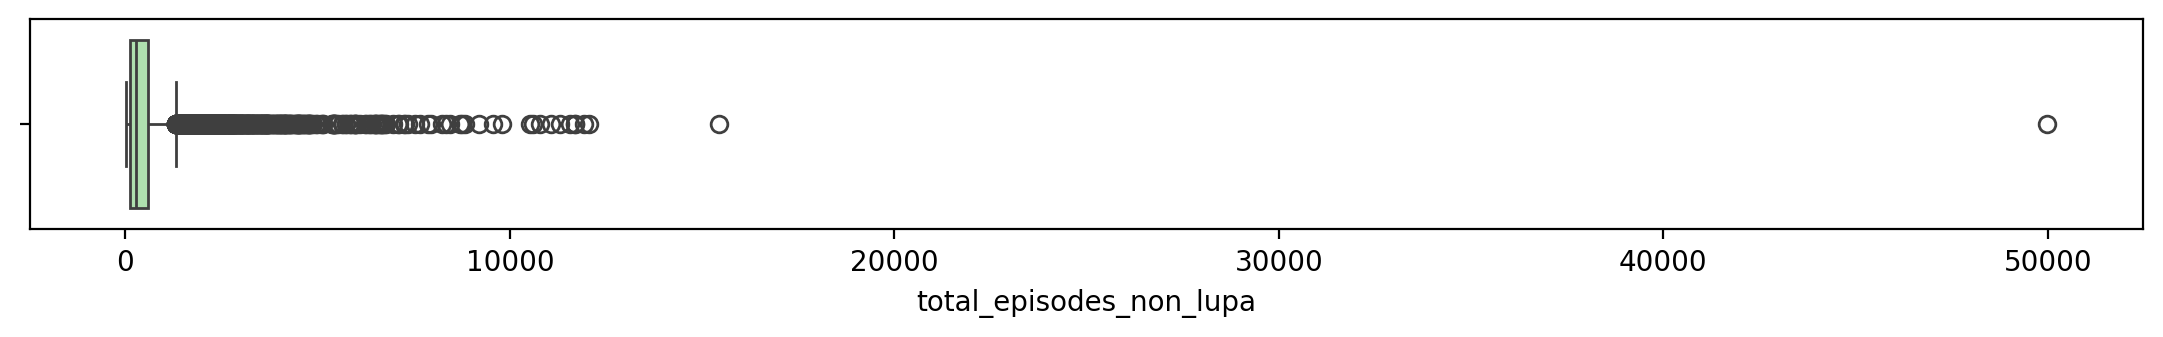

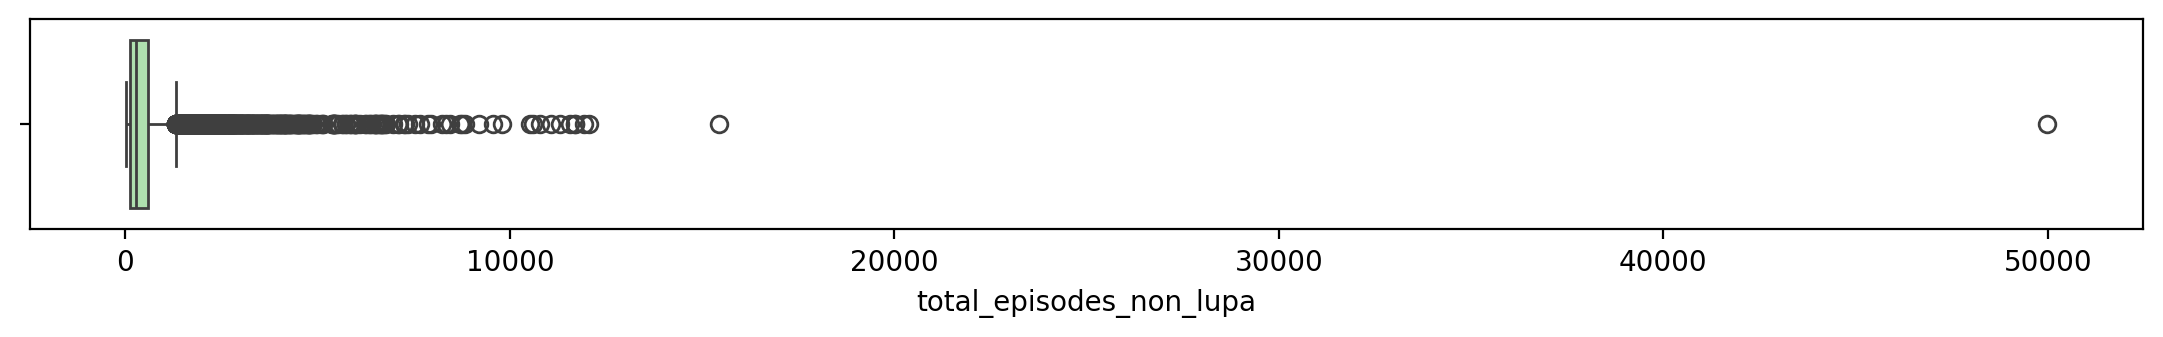

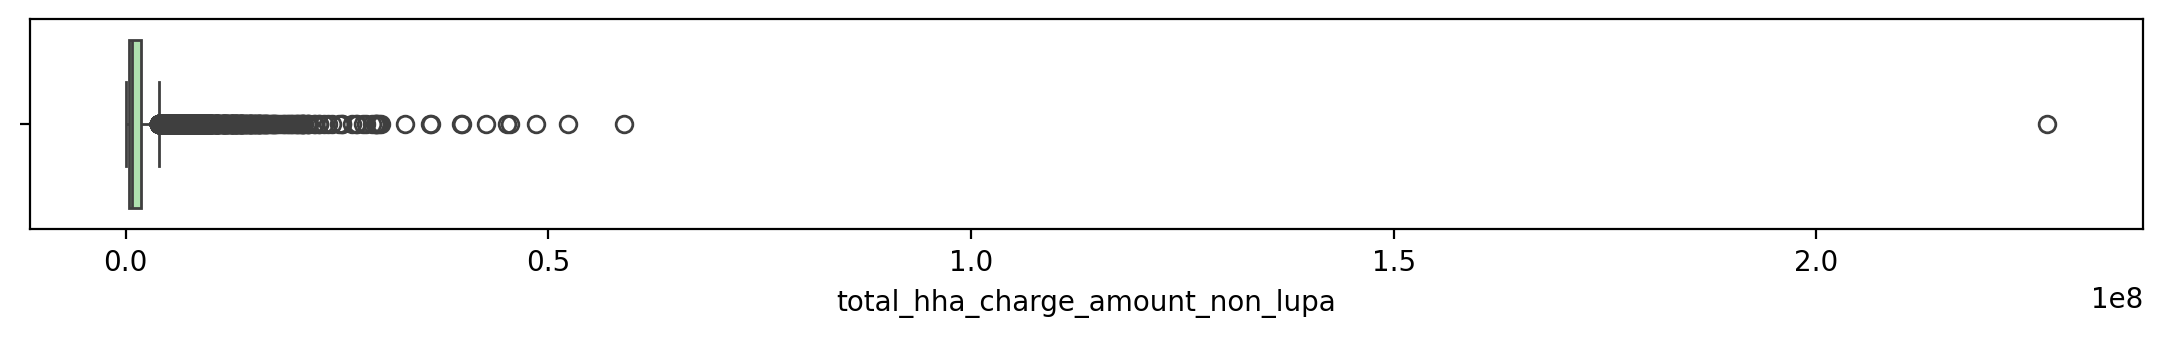

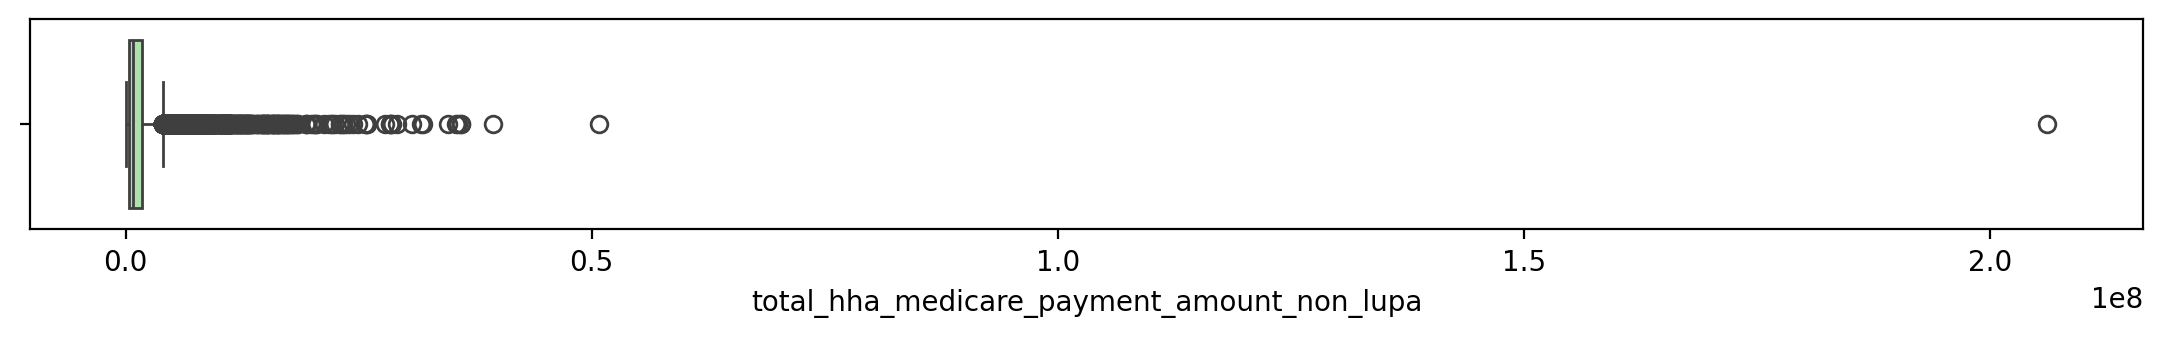

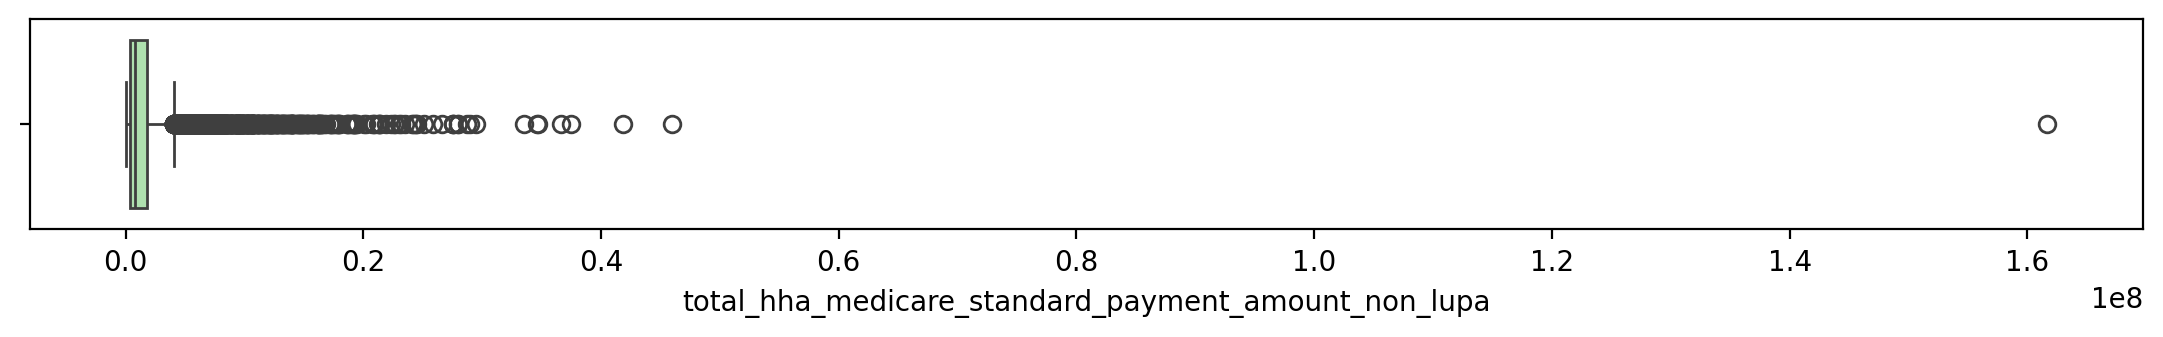

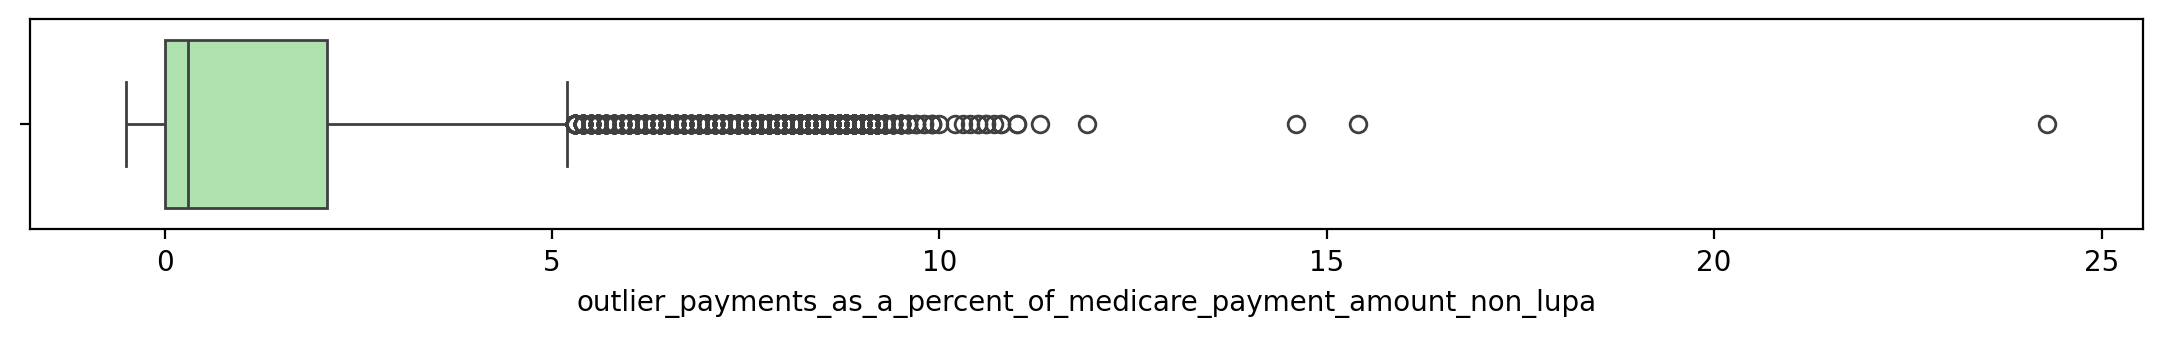

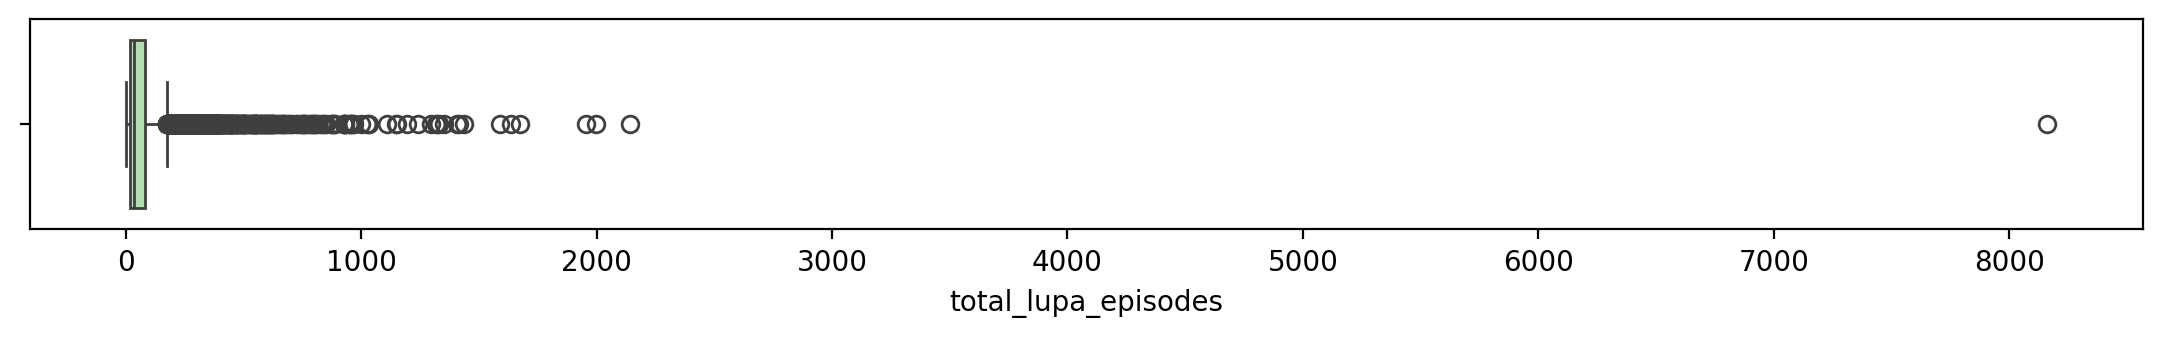

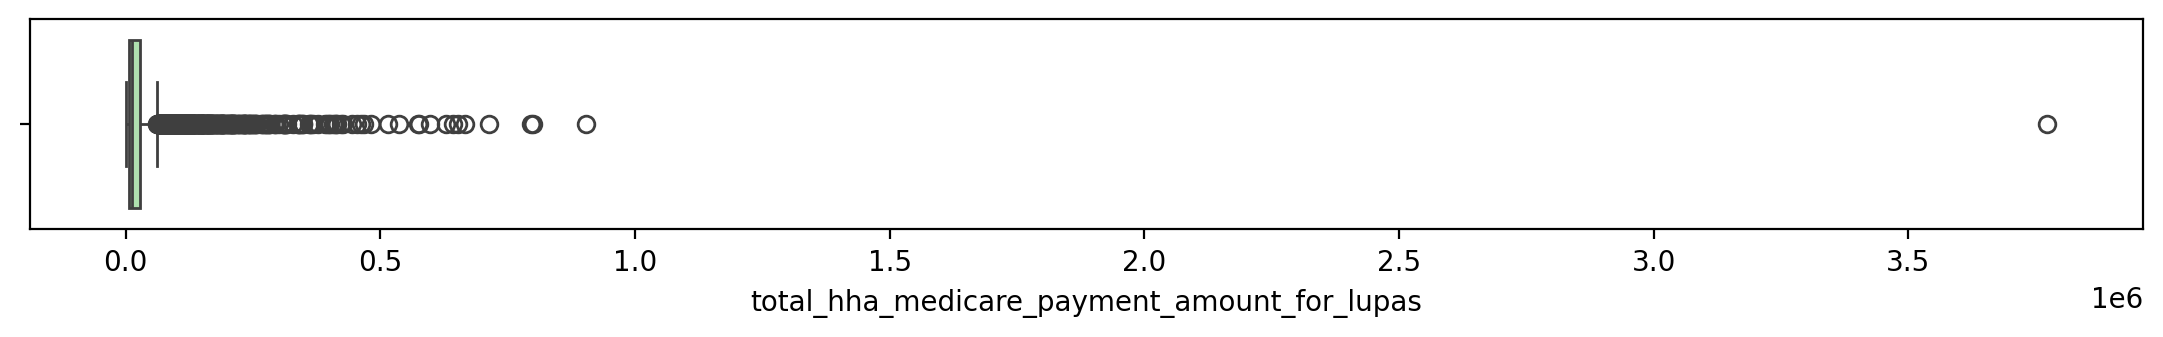

In [37]:
Numerical = ['total_episodes_non_lupa', 'total_episodes_non_lupa',
             'total_hha_charge_amount_non_lupa','total_hha_medicare_payment_amount_non_lupa',
             'total_hha_medicare_standard_payment_amount_non_lupa',
             'outlier_payments_as_a_percent_of_medicare_payment_amount_non_lupa',
             'total_lupa_episodes','total_hha_medicare_payment_amount_for_lupas']
i = 0
while i < 8:
    fig = plt.figure(figsize = [30,3], dpi=200)
    plt.subplot(2,2,1)
    sns.boxplot(x = Numerical[i], data = df_home_health_2014,
           boxprops = dict(facecolor = "#AFE1AF"))
    i += 1
    plt.show()

In [38]:
_noise2 = df_home_health_2014[df_home_health_2014["total_episodes_non_lupa"]>13000].index
print(_noise2)
df_home_health_2014.loc[_noise2].style.set_properties(**{'background-color': '#AFE1AF',
                           'color': 'black',
                           'border-color': 'black'})

Index([535, 3869], dtype='int64')


In [39]:
df_home_health_2014.drop(index=_noise2, inplace=True)

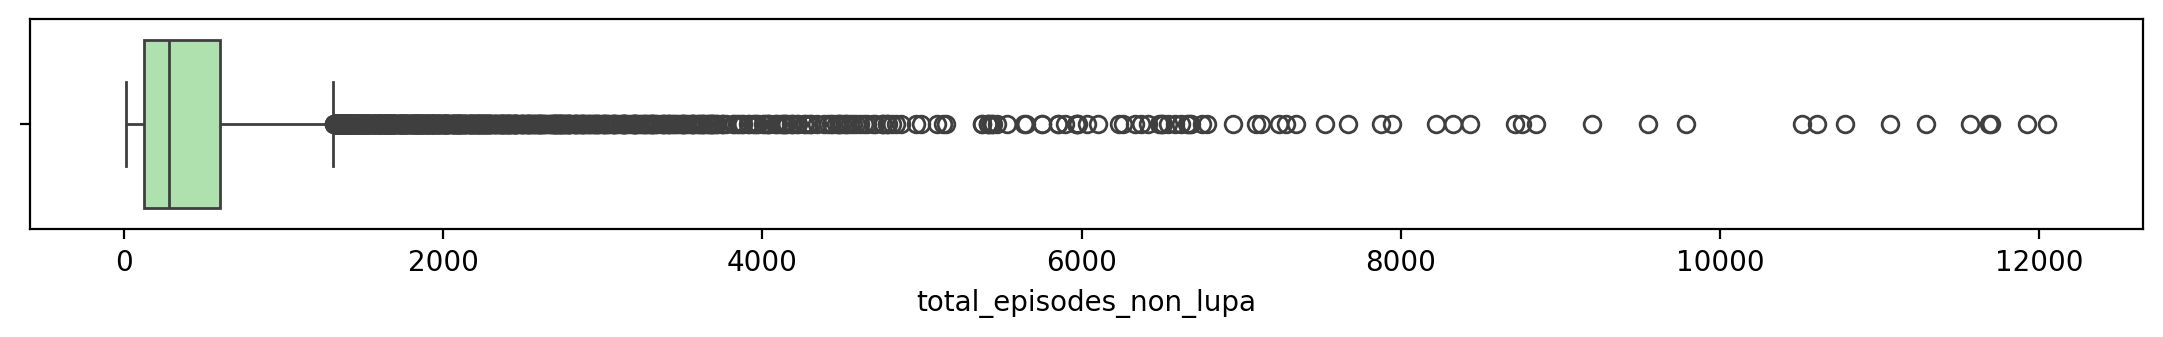

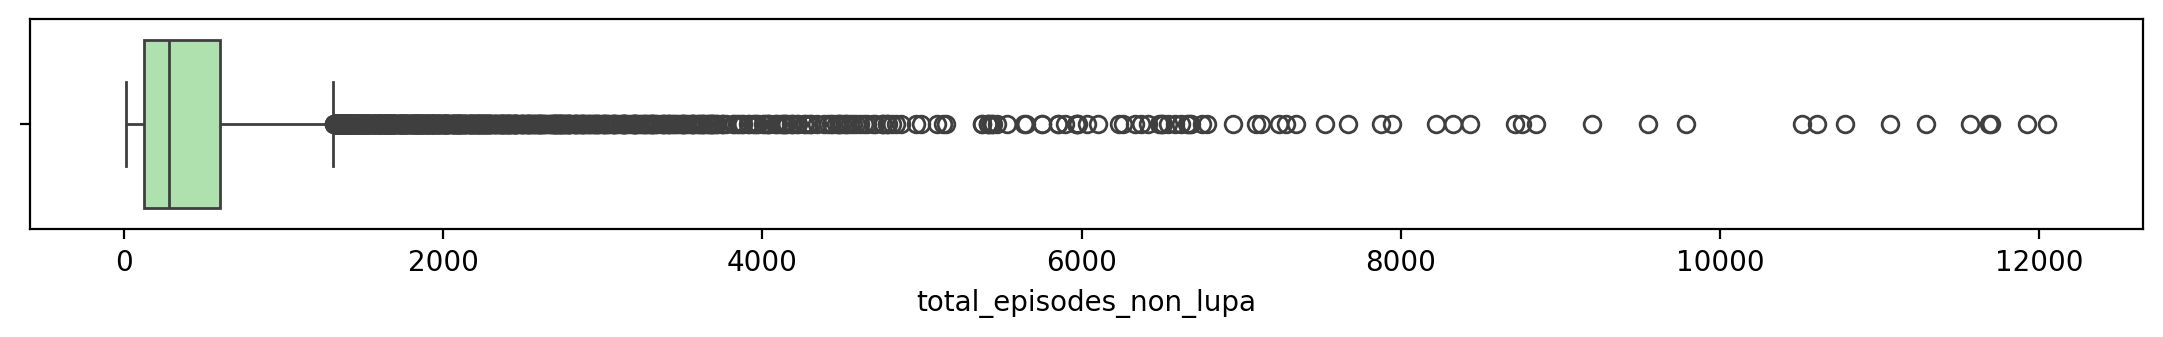

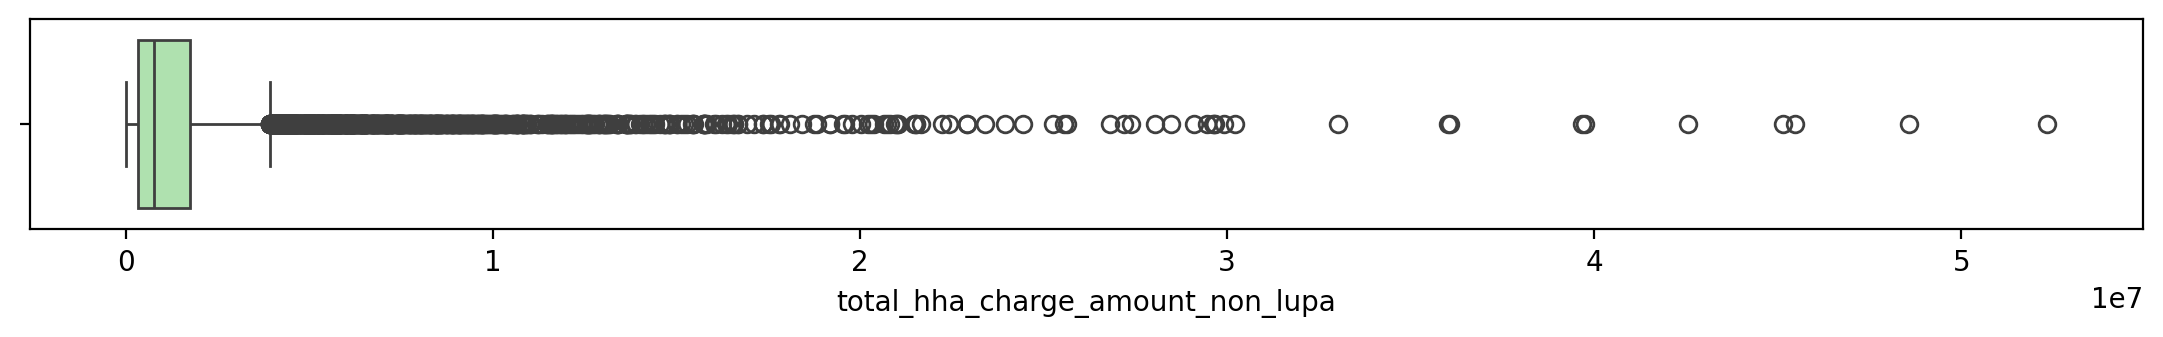

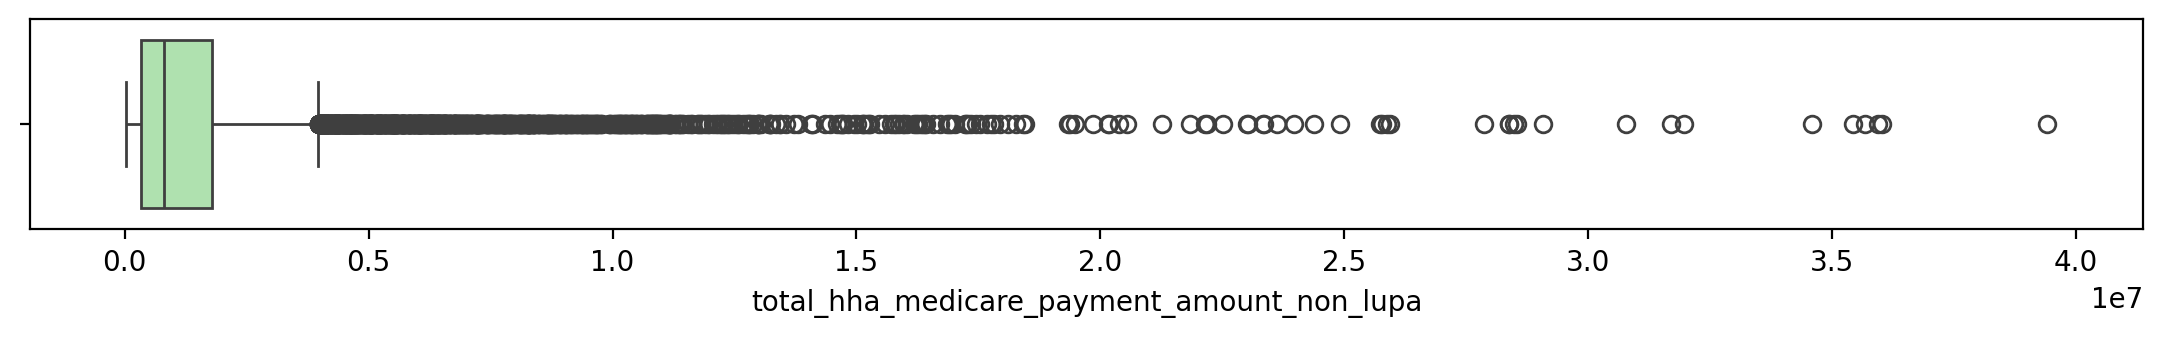

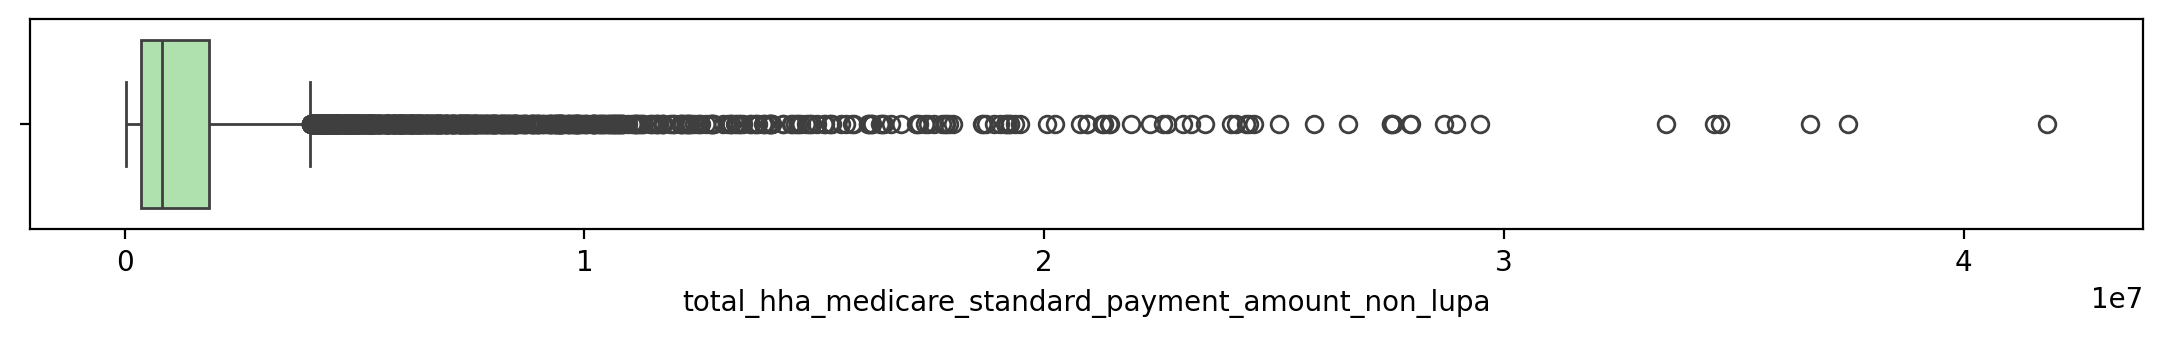

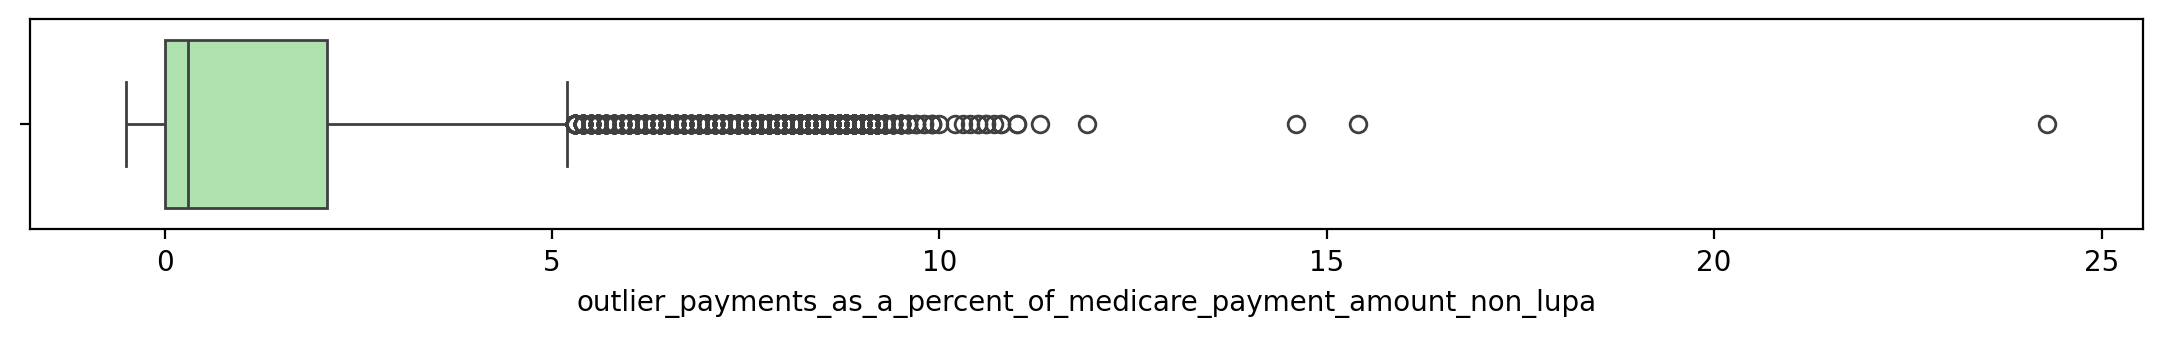

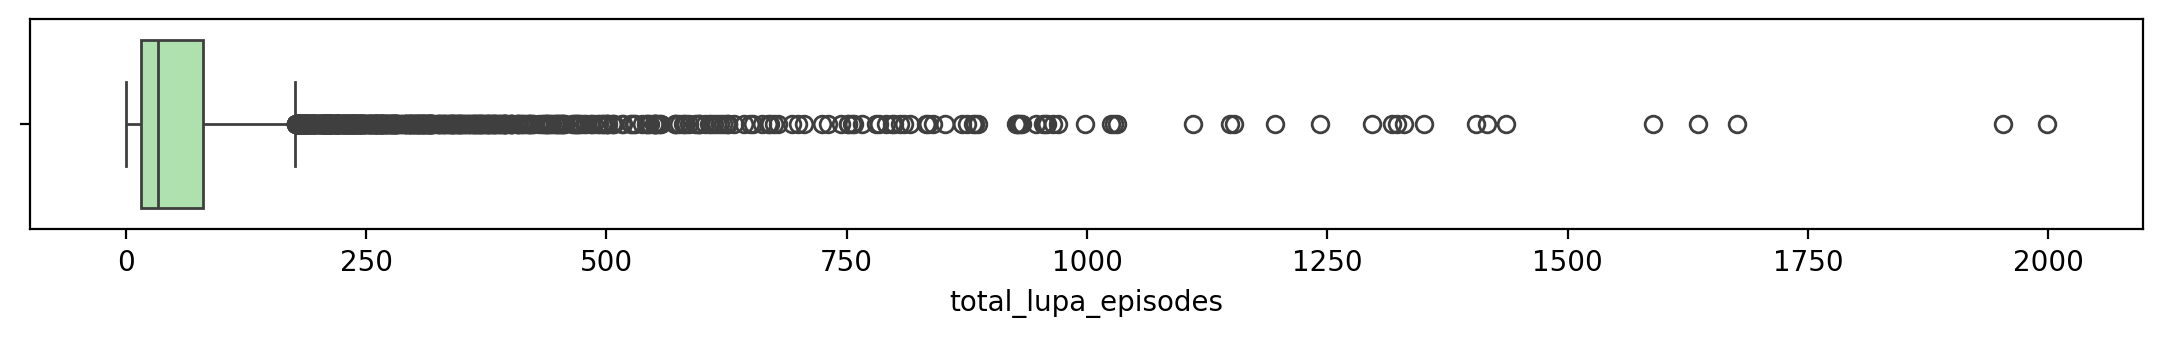

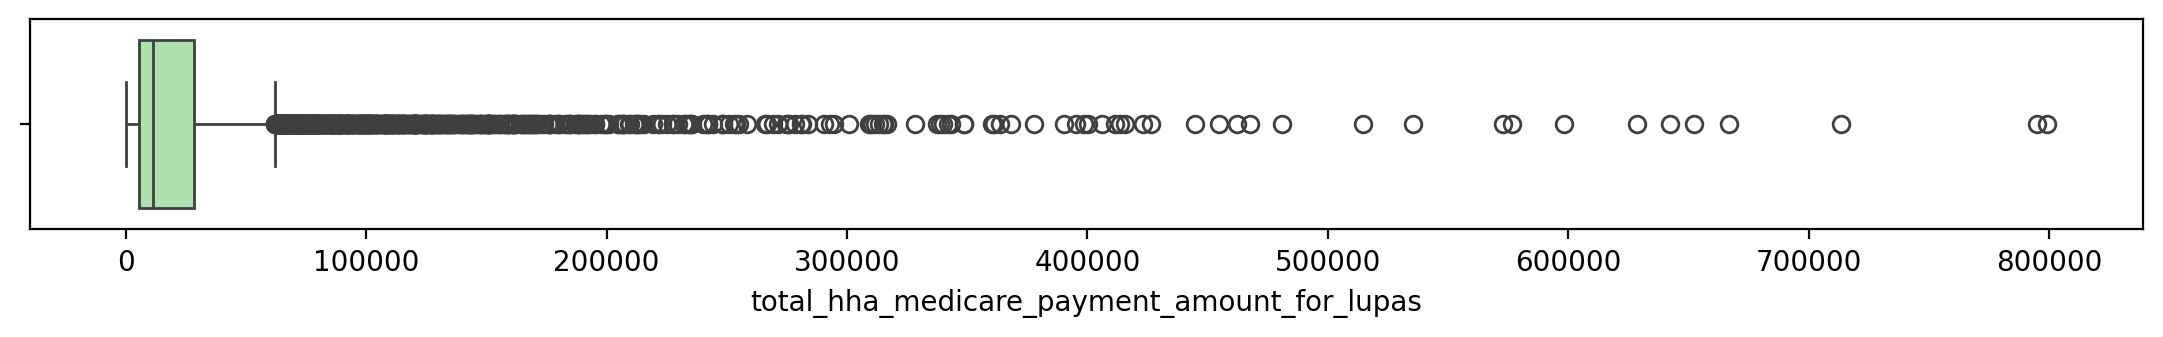

In [40]:
Numerical = ['total_episodes_non_lupa', 'total_episodes_non_lupa',
             'total_hha_charge_amount_non_lupa','total_hha_medicare_payment_amount_non_lupa',
             'total_hha_medicare_standard_payment_amount_non_lupa',
             'outlier_payments_as_a_percent_of_medicare_payment_amount_non_lupa',
             'total_lupa_episodes','total_hha_medicare_payment_amount_for_lupas']
i = 0
while i < 8:
    fig = plt.figure(figsize = [30,3], dpi=200)
    plt.subplot(2,2,1)
    sns.boxplot(x = Numerical[i], data = df_home_health_2014,
           boxprops = dict(facecolor = "#AFE1AF"))
    i += 1
    plt.show()

In [41]:
df_home_health_2014['Latitude'] = df_home_health_2014['Latitude'].astype('float')
df_home_health_2014['Longitude'] = df_home_health_2014['Longitude'].astype('float')

fig = px.scatter_mapbox(df_home_health_2014, lat="Latitude", lon="Longitude", 
                        hover_name="total_episodes_non_lupa",
                        size = "total_hha_charge_amount_non_lupa",
                        color_discrete_sequence=["green"], zoom=3.5, height=500)

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.update_layout(
    annotations = [dict(x=0.5, y=0.9,
                      bgcolor= "#00FFFF",
                      showarrow=False,
                      text = "total_episodes_non_lupa and total_hha_charge_amount_non_lupa 2014")],
    title_x=0.5,
    title_y=0.9,
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [43]:
from google.cloud import bigquery
import pandas as pd
import plotly.offline as pyo
import plotly.graph_objs as go

# Initialize the BigQuery client
client = bigquery.Client()

# Define the query
Query4 = """SELECT
state, COUNT(state) as total_facilities
FROM
  `bigquery-public-data.cms_medicare.home_health_agencies_2014`
GROUP BY 
  state
ORDER BY
  total_facilities DESC;"""

# Execute the query and convert the result to a Pandas DataFrame
query_job = client.query(Query4)
response2 = query_job.to_dataframe()

# Display the top 10 rows
print(response2.head(10))

# Create the data for the choropleth
data = [go.Choropleth(
    colorscale='greens',
    autocolorscale=False,
    locations=response2['state'],
    z=response2['total_facilities'],
    locationmode='USA-states',
    text=response2['state'],
    marker=dict(
        line=dict(
            color='rgb(255,255,255)',
            width=2
        )),
    colorbar=dict(
        title="Facilities in Different States 2014")
)]

# Define the layout
layout = go.Layout(
    title='Home Health Agencies Facilities in Different States 2014',
    geo=dict(
        scope='usa',
        projection=dict(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    )
)

# Create and display the figure
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig, filename='d3-cloropleth-map')


  state  total_facilities
0    TX              2340
1    FL              1158
2    CA              1135
3    IL               767
4    MI               610
5    OH               526
6    PA               303
7    OK               257
8    VA               211
9    IN               206


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



Groupby Comparison

An alternative approach, similar to using SQL queries, is to use Python's groupby function to group variables by a column and compare different methods across states for the years 2013 and 2014.

In [44]:
df_home_health_2013.columns

Index(['provider_id', 'agency_name', 'street_address', 'city', 'state',
       'zip_code', 'total_episodes_non_lupa', 'distinct_users_non_lupa',
       'total_hha_charge_amount_non_lupa',
       'total_hha_medicare_payment_amount_non_lupa',
       'total_hha_medicare_standard_payment_amount_non_lupa',
       'outlier_payments_as_a_percent_of_medicare_payment_amount_non_lupa',
       'total_lupa_episodes', 'total_hha_medicare_payment_amount_for_lupas'],
      dtype='object')

In [45]:
df_home_health_2013_group_state = df_home_health_2013.groupby('state').sum()
df_home_health_2014_group_state = df_home_health_2014.groupby('state').sum()

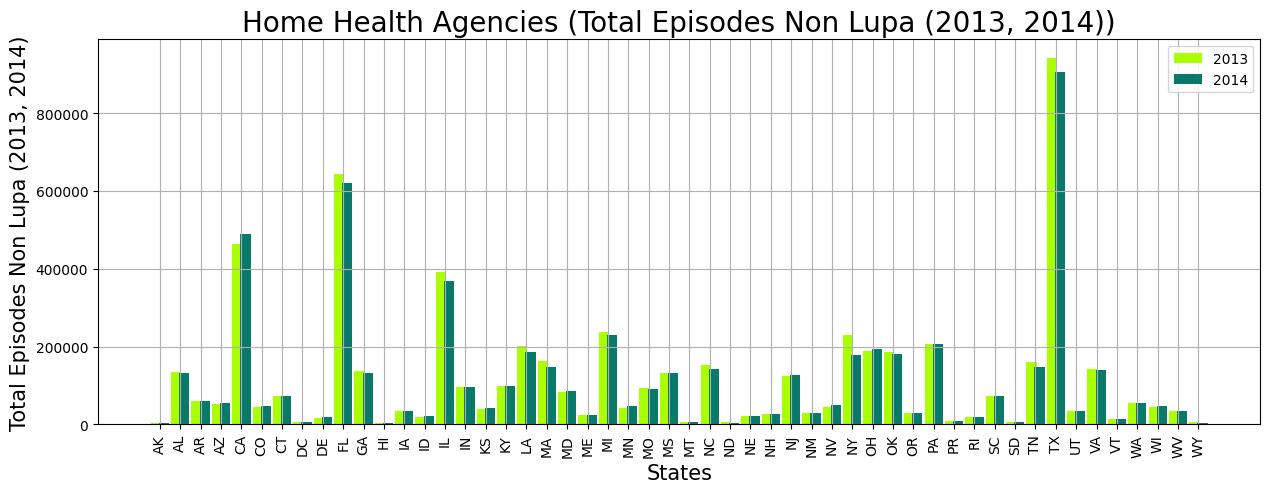

In [46]:
plt.figure(figsize=(15,5))

X_axis = np.arange(len(df_home_health_2013_group_state.index))

plt.bar(X_axis - 0.2, df_home_health_2013_group_state['total_episodes_non_lupa']
        , width=0.5, label = '2013', color='#AAFF00')
plt.bar(X_axis + 0.2, df_home_health_2014_group_state['total_episodes_non_lupa']
        , width=0.5, label = '2014', color='#097969')

plt.xticks(X_axis, df_home_health_2013_group_state.index,rotation = 90)

plt.xlabel("States", fontsize=15)
plt.ylabel("Total Episodes Non Lupa (2013, 2014)", fontsize=15)

plt.title("Home Health Agencies (Total Episodes Non Lupa (2013, 2014))", fontsize=20)

plt.legend(['2013', '2014'])

plt.grid()


plt.show()

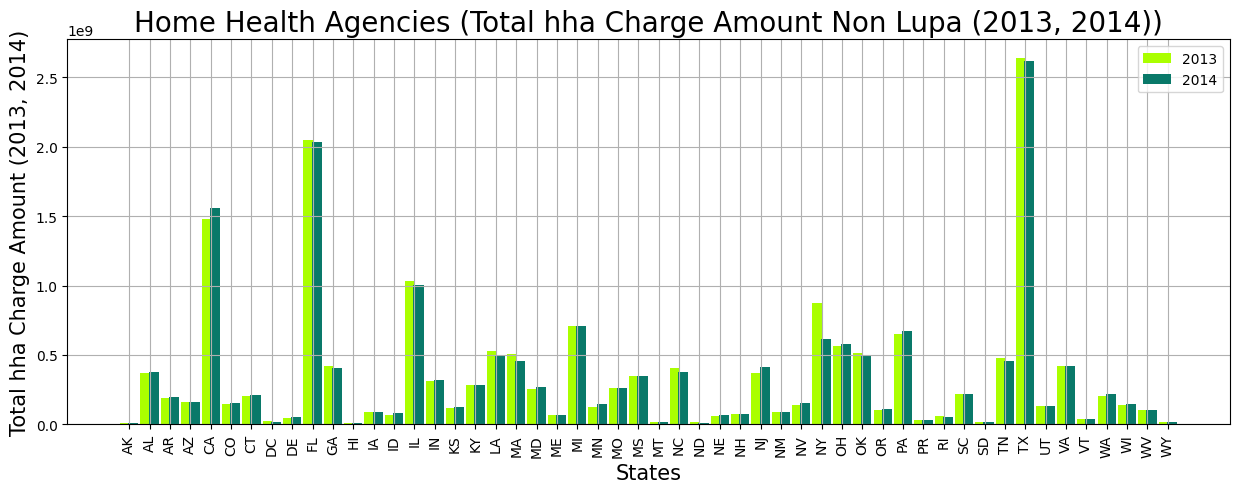

In [47]:
plt.figure(figsize=(15,5))

X_axis = np.arange(len(df_home_health_2013_group_state.index))

plt.bar(X_axis - 0.2, df_home_health_2013_group_state['total_hha_charge_amount_non_lupa']
        , width=0.5, label = '2013', color='#AAFF00')
plt.bar(X_axis + 0.2, df_home_health_2014_group_state['total_hha_charge_amount_non_lupa']
        , width=0.5, label = '2014', color='#097969')

plt.xticks(X_axis, df_home_health_2013_group_state.index,rotation = 90)

plt.xlabel("States", fontsize=15)
plt.ylabel("Total hha Charge Amount (2013, 2014)", fontsize=15)

plt.title("Home Health Agencies (Total hha Charge Amount Non Lupa (2013, 2014))", fontsize=20)

plt.legend(['2013', '2014'])

plt.grid()


plt.show()